# Predicting All Black Losses (2)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,roc_curve, auc, average_precision_score, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
abmatchdata = pd.read_csv('ABMatchData(FULL).csv')

In [3]:
abmatchdata.head()

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss
0,Canada,2003-10-17,62,Melbourne,0,1,9,28,65.62,89.80,8
1,Tonga,2003-10-24,84,Brisbane,1,1,13,31,70.08,89.80,9
2,Wales,2003-11-02,16,Sydney,0,0,17,37,76.92,89.80,10
3,South Africa,2003-11-08,20,Melbourne,0,0,28,44,81.84,89.80,11
4,Australia,2003-11-15,-12,Sydney,0,0,41,45,86.20,90.41,12


## 1.0 Feature Engineering

In [4]:
#enumerate the location column. 0 for a neutral venue, -1 for away and 1 for home, and then create dummy columns.
#home cities and neutral game indexes. Neutral games have only ever happened during a worldcup plus a handful of other games
#luckily, neutral games arent common and their indexes can be found easily manually, especially with domain knowledge
AB_neutral_games = [0,1,2,3,5,49,50,52,53,64,78,92,156,157,158,159,160,161,162,173,200]

In [5]:
#add our venue column
abmatchdata['Venue'] = 0

In [6]:
#define a function to enumerate the location column for neutral games only
def enum_nut(neutral_games,MatchData):
    location_num = []
    for x in range (0,len(MatchData['Location'])):
        if x in neutral_games:
            location_num.append(0)
        else:
            location_num.append(-1)
    return location_num

In [7]:
abmatchdata['Venue'] = enum_nut(AB_neutral_games,abmatchdata)

In [8]:
abmatchdata['Venue'].head(10)

0    0
1    0
2    0
3    0
4   -1
5    0
6   -1
7   -1
8   -1
9   -1
Name: Venue, dtype: int64

In [9]:
#Now to just add 1's for home games
AB_homecols = [ 'Dunedin', 'Auckland','Hamilton', 'North Shore City', 'Wellington', 'Christchurch', 'New Plymouth','Napier','Nelson']

In [10]:
#loop through and add 1 where needed
for x in range (0,len(abmatchdata['Location'])):
    if abmatchdata.loc[x,'Location'] in AB_homecols:
        abmatchdata.loc[x,'Venue'] = 1

In [11]:
#check if venue column is complete
abmatchdata.head(10)

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue
0,Canada,2003-10-17,62,Melbourne,0,1,9,28,65.62,89.80,8,0
1,Tonga,2003-10-24,84,Brisbane,1,1,13,31,70.08,89.80,9,0
2,Wales,2003-11-02,16,Sydney,0,0,17,37,76.92,89.80,10,0
3,South Africa,2003-11-08,20,Melbourne,0,0,28,44,81.84,89.80,11,0
4,Australia,2003-11-15,-12,Sydney,0,0,41,45,86.20,90.41,12,-1
5,France,2003-11-20,27,Sydney,0,0,21,35,84.66,88.17,1,0
6,England,2004-06-12,33,Dunedin,1,3,17,31,90.56,90.12,2,1
7,England,2004-06-19,24,Auckland,2,1,10,21,89.44,91.23,3,1
8,Argentina,2004-06-26,34,Hamilton,1,1,48,18,78.59,92.01,4,1
9,Pacific Is,2004-07-10,15,North Shore City,2,1,2,20,69.00,92.31,5,1


In [12]:
#get dummy columns
abdummy_cols = pd.get_dummies(abmatchdata['Venue'],prefix = 'Ven')

In [13]:
#Add columns back to df
abmatchdata = pd.concat([abmatchdata,abdummy_cols], axis =1)

In [14]:
#Check dataframes
abmatchdata

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue,Ven_-1,Ven_0,Ven_1
0,Canada,2003-10-17,62,Melbourne,0,1,9,28,65.62,89.80,8,0,0,1,0
1,Tonga,2003-10-24,84,Brisbane,1,1,13,31,70.08,89.80,9,0,0,1,0
2,Wales,2003-11-02,16,Sydney,0,0,17,37,76.92,89.80,10,0,0,1,0
3,South Africa,2003-11-08,20,Melbourne,0,0,28,44,81.84,89.80,11,0,0,1,0
4,Australia,2003-11-15,-12,Sydney,0,0,41,45,86.20,90.41,12,-1,1,0,0
5,France,2003-11-20,27,Sydney,0,0,21,35,84.66,88.17,1,0,0,1,0
6,England,2004-06-12,33,Dunedin,1,3,17,31,90.56,90.12,2,1,0,0,1
7,England,2004-06-19,24,Auckland,2,1,10,21,89.44,91.23,3,1,0,0,1
8,Argentina,2004-06-26,34,Hamilton,1,1,48,18,78.59,92.01,4,1,0,0,1
9,Pacific Is,2004-07-10,15,North Shore City,2,1,2,20,69.00,92.31,5,1,0,0,1


In [15]:
#Add an extra column for enumerating the result column; 1 for a win/draw and 0 for a loss and then look for clusters
#define function for enumerating Results
def enum_res(matchdata):
    matchdata['ResultBin']=1
    for x in range(0,len(matchdata['Result'])):
        if matchdata.loc[x,'Result'] < 0:
            matchdata.loc[x,'ResultBin'] = 0

In [16]:
enum_res(abmatchdata)

In [17]:
abmatchdata.head(5)

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue,Ven_-1,Ven_0,Ven_1,ResultBin
0,Canada,2003-10-17,62,Melbourne,0,1,9,28,65.62,89.80,8,0,0,1,0,1
1,Tonga,2003-10-24,84,Brisbane,1,1,13,31,70.08,89.80,9,0,0,1,0,1
2,Wales,2003-11-02,16,Sydney,0,0,17,37,76.92,89.80,10,0,0,1,0,1
3,South Africa,2003-11-08,20,Melbourne,0,0,28,44,81.84,89.80,11,0,0,1,0,1
4,Australia,2003-11-15,-12,Sydney,0,0,41,45,86.20,90.41,12,-1,1,0,0,0


Finally, I will add a third column for month only.

In [18]:
months = list()
for date in abmatchdata['Date']:
    months.append(int(date[5]+date[6]))

In [19]:
abmatchdata['months'] = months

In [20]:
abmatchdata.head(5)

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue,Ven_-1,Ven_0,Ven_1,ResultBin,months
0,Canada,2003-10-17,62,Melbourne,0,1,9,28,65.62,89.80,8,0,0,1,0,1,10
1,Tonga,2003-10-24,84,Brisbane,1,1,13,31,70.08,89.80,9,0,0,1,0,1,10
2,Wales,2003-11-02,16,Sydney,0,0,17,37,76.92,89.80,10,0,0,1,0,1,11
3,South Africa,2003-11-08,20,Melbourne,0,0,28,44,81.84,89.80,11,0,0,1,0,1,11
4,Australia,2003-11-15,-12,Sydney,0,0,41,45,86.20,90.41,12,-1,1,0,0,0,11


In [21]:
numeric_cols = ['Opposition Debutants','Debutants','Opposition tries in last 5 games','Tries in last 5 games','Opposition Rating','Rating','Games since last loss','Ven_-1','Ven_0','Ven_1','months']

In [22]:
num_data = abmatchdata[numeric_cols]

In [23]:
num_data.head(5)

,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Ven_-1,Ven_0,Ven_1,months
0,0,1,9,28,65.62,89.80,8,0,1,0,10
1,1,1,13,31,70.08,89.80,9,0,1,0,10
2,0,0,17,37,76.92,89.80,10,0,1,0,11
3,0,0,28,44,81.84,89.80,11,0,1,0,11
4,0,0,41,45,86.20,90.41,12,1,0,0,11


In [24]:
#save target
y_databin = abmatchdata['ResultBin']
y_data = abmatchdata['Result']

In [25]:
#normalize numeric data
norm_data=((num_data-num_data.min())/(num_data.max()-num_data.min()))

In [26]:
norm_data.head(5)

,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Ven_-1,Ven_0,Ven_1,months
0,0.000000,0.125,0.152174,0.523810,0.126087,0.188222,0.318182,0.0,1.0,0.0,0.666667
1,0.090909,0.125,0.239130,0.595238,0.275251,0.188222,0.363636,0.0,1.0,0.0,0.666667
2,0.000000,0.000,0.326087,0.738095,0.504013,0.188222,0.409091,0.0,1.0,0.0,0.833333
3,0.000000,0.000,0.565217,0.904762,0.668562,0.188222,0.454545,0.0,1.0,0.0,0.833333
4,0.000000,0.000,0.847826,0.928571,0.814381,0.258661,0.500000,1.0,0.0,0.0,0.833333


In [27]:
all_data = norm_data

In [28]:
all_data['ResultBin'] = y_databin
all_data['Result'] = y_data

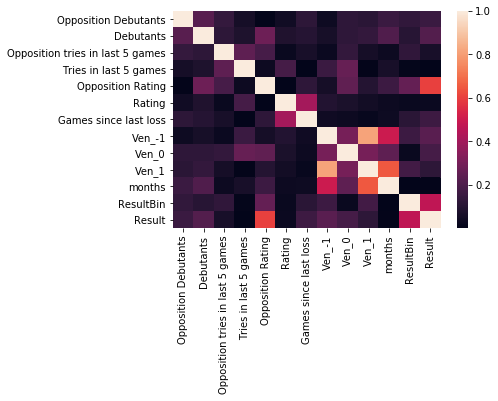

In [29]:
#generate a correlation matrix heatmap to select features for regression
abcorrmat = all_data.corr().abs()
sns.heatmap(abcorrmat)

In [30]:
all_data.corr()

,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Ven_-1,Ven_0,Ven_1,months,ResultBin,Result
Opposition Debutants,1.000000,0.228839,-0.140814,-0.057091,-0.004841,0.044934,-0.119167,-0.035657,-0.125374,0.112092,-0.155173,0.129980,0.155380
Debutants,0.228839,1.000000,-0.119014,-0.081233,-0.279492,-0.085494,-0.101807,-0.060781,-0.124803,0.136868,-0.210364,0.105401,0.216510
Opposition tries in last 5 games,-0.140814,-0.119014,1.000000,0.245310,0.185962,0.027528,-0.066222,-0.028037,0.136834,-0.055385,0.033166,-0.128686,-0.065341
Tries in last 5 games,-0.057091,-0.081233,0.245310,1.000000,-0.032281,0.181441,-0.000501,-0.152779,0.262892,-0.007495,0.063474,-0.008817,0.001962
Opposition Rating,-0.004841,-0.279492,0.185962,-0.032281,1.000000,-0.004186,0.122514,0.055853,-0.249984,0.096551,-0.159857,-0.259729,-0.602989
Rating,0.044934,-0.085494,0.027528,0.181441,-0.004186,1.000000,0.408947,0.092919,-0.073408,-0.048165,0.035178,-0.026165,-0.030852
Games since last loss,-0.119167,-0.101807,-0.066222,-0.000501,0.122514,0.408947,1.000000,0.041096,-0.034106,-0.020303,0.038260,-0.113321,-0.161246
Ven_-1,-0.035657,-0.060781,-0.028037,-0.152779,0.055853,0.092919,0.041096,1.000000,-0.304828,-0.814159,0.501029,-0.159521,-0.231380
Ven_0,-0.125374,-0.124803,0.136834,0.262892,-0.249984,-0.073408,-0.034106,-0.304828,1.000000,-0.304828,0.243427,-0.027093,0.183768
Ven_1,0.112092,0.136868,-0.055385,-0.007495,0.096551,-0.048165,-0.020303,-0.814159,-0.304828,1.000000,-0.649436,0.176038,0.119345


Overall, the correlation indices to ResultBin are quite weak. (Indices of the Result column are much better ).

In [31]:
#first we resample our data(80/20 split) 
all_train = all_data.sample(frac=0.8,random_state=200)
all_test = all_data.drop(all_train.index)

In [32]:
#resample the training data (50/50) to train and test base models
base_train = all_train.sample(frac=0.5, random_state=200)
base_test = all_train.drop(base_train.index)

In [83]:
len(base_test)

82

In [34]:
base_train.head(5)

,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Ven_-1,Ven_0,Ven_1,months,ResultBin,Result
201,0.181818,1.000,0.347826,0.476190,0.447826,0.553118,0.136364,1.0,0.0,0.0,0.833333,1,38
144,0.000000,0.125,0.130435,0.238095,0.405351,0.644342,0.954545,1.0,0.0,0.0,0.500000,1,21
149,0.000000,0.125,0.195652,0.476190,0.549164,0.638568,0.136364,1.0,0.0,0.0,0.833333,1,8
99,0.000000,0.000,0.347826,0.571429,0.829431,0.579677,0.272727,0.0,0.0,1.0,0.333333,1,16
72,0.090909,0.000,0.282609,0.119048,0.818729,0.292148,0.090909,0.0,0.0,1.0,0.166667,1,6


In [35]:
base_test.head(5)

,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Ven_-1,Ven_0,Ven_1,months,ResultBin,Result
69,0.181818,0.375,0.260870,0.190476,0.605351,0.523095,0.409091,0.0,0.0,1.0,0.000000,0,-5
132,0.090909,0.000,0.173913,0.285714,0.749164,0.563510,0.409091,0.0,0.0,1.0,0.666667,1,8
192,0.090909,0.000,0.130435,0.404762,0.576923,0.672055,0.181818,0.0,0.0,1.0,0.000000,1,13
100,0.000000,0.000,0.086957,0.476190,0.743478,0.587760,0.318182,1.0,0.0,0.0,0.333333,0,-13
22,0.000000,0.000,0.521739,0.523810,0.857525,0.193995,0.000000,1.0,0.0,0.0,0.333333,1,17


In [87]:
y_basetest = base_test['Result']
y_basetest_bin = base_test['ResultBin']

In [88]:
x_basetest = base_test.drop(['Result','ResultBin'],axis = 1)

In [89]:
x_basetest.head()

,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Ven_-1,Ven_0,Ven_1,months
69,0.181818,0.375,0.260870,0.190476,0.605351,0.523095,0.409091,0.0,0.0,1.0,0.000000
132,0.090909,0.000,0.173913,0.285714,0.749164,0.563510,0.409091,0.0,0.0,1.0,0.666667
192,0.090909,0.000,0.130435,0.404762,0.576923,0.672055,0.181818,0.0,0.0,1.0,0.000000
100,0.000000,0.000,0.086957,0.476190,0.743478,0.587760,0.318182,1.0,0.0,0.0,0.333333
22,0.000000,0.000,0.521739,0.523810,0.857525,0.193995,0.000000,1.0,0.0,0.0,0.333333


In [90]:
y_test_bin.shape

(82,)

In [39]:
y_basetrain = base_train['Result']
y_basetrain_bin = base_train['ResultBin']

In [40]:
x_basetrain = base_train.drop(['Result','ResultBin'],axis = 1)
x_basetrain.head()

,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Ven_-1,Ven_0,Ven_1,months
201,0.181818,1.000,0.347826,0.476190,0.447826,0.553118,0.136364,1.0,0.0,0.0,0.833333
144,0.000000,0.125,0.130435,0.238095,0.405351,0.644342,0.954545,1.0,0.0,0.0,0.500000
149,0.000000,0.125,0.195652,0.476190,0.549164,0.638568,0.136364,1.0,0.0,0.0,0.833333
99,0.000000,0.000,0.347826,0.571429,0.829431,0.579677,0.272727,0.0,0.0,1.0,0.333333
72,0.090909,0.000,0.282609,0.119048,0.818729,0.292148,0.090909,0.0,0.0,1.0,0.166667


In [91]:
y_test = all_test['Result']
y_test_bin = all_test['ResultBin']
x_test = all_test.drop(['Result','ResultBin'],axis = 1)
x_test.head()

,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Ven_-1,Ven_0,Ven_1,months
1,0.090909,0.125,0.239130,0.595238,0.275251,0.188222,0.363636,0.0,1.0,0.0,0.666667
7,0.181818,0.125,0.173913,0.357143,0.922742,0.353349,0.090909,0.0,0.0,1.0,0.000000
14,0.090909,0.500,0.282609,0.095238,0.350167,0.168591,0.000000,1.0,0.0,0.0,0.833333
16,0.000000,0.000,0.282609,0.214286,0.772241,0.172055,0.090909,1.0,0.0,0.0,0.833333
20,0.000000,0.125,0.086957,0.571429,0.625753,0.315242,0.272727,0.0,0.0,1.0,0.166667


In [95]:
x_basetrain.shape

(82, 11)

# 2.0 Base Modelling
Before we start modelling lets first establish some metrics to assess our models. We will avoid simple accuracy and instead use other measures of effectiveness that give us more granularity than simple accuracy, lets use ***Specificty*** and ***Sensitivity*** 

In [43]:
#define function to get Specificity and Sensitivity
def get_rates(predictions,data):
# False positives.
    fp_filter = (predictions == 1) & (data == 0)
    fp = len(predictions[fp_filter])

# True positives.
    tp_filter = (predictions == 1) & (data == 1)
    tp = len(predictions[tp_filter])

# False negatives.
    fn_filter = (predictions == 0) & (data == 1)
    fn = len(predictions[fn_filter])

# True negatives
    tn_filter = (predictions == 0) & (data == 0)
    tn = len(predictions[tn_filter])
# Rates
    spec = tn  / (tn + fp)#true negative rate
    sens = tp  / (tp + fn)#true positive rate
    return(spec,sens)

It is also worth noting that in our test set, there are only 2/41 negative cases. We will also be generating ***AUC-ROC curves***. I will also make a function to handle all fitting, predicting and evaluation tasks

In [108]:
#we will also define a function to handle all fitting and prediction tasks with grid search
def fitandpredict(model, hyperparams):
    #create grid search with 2 fold cross validation
    gridsearch = GridSearchCV(model, hyperparams, cv=5, verbose=1)
    # Fit grid search
    best_model = gridsearch.fit(x_basetrain, y_basetrain_bin)
    # View best hyperparameters
    print('-----------------------------------------------------------------------')
    print('Best Penalty:', best_model.best_estimator_.get_params())
    print('-----------------------------------------------------------------------')
    #make prediction
    predictions = best_model.predict(x_basetest)
    spec, sens = get_rates(predictions, y_basetest_bin)
    print('SPECIFICITY: ',spec)
    print('SENSITIVITY: ',sens)
    print('FPR: ',1-spec)
    print('-----------------------------------------------------------------------')
    try:
        probs = best_model.predict_proba(x_basetest)
        preds = probs[:,1]#keep probabilities for the positive outcome only
        fpr, tpr, threshold = metrics.roc_curve(y_basetest_bin, preds)
        roc_auc = metrics.auc(fpr, tpr)
# plot ROC
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        print('AUC Score:',roc_auc)
        return(predictions,probs, best_model)
    except:
        print('MODEL DOES NOT RETURN PROBS, ONLY PREDICTIONS')
        return(predictions,0, best_model)

Make a dataframe to house all base predictions and actual results(**pred_stack**), another dataframe for probabilities only of the base predictions(**metatrain_stack**),another dataframe for predictions also made with the base models but on our test data(**metatest_stack**) and a final DataFrame that will house our final Meta Models' predictions on(**final_pred_stack**).

In [128]:
pred_stack = pd.DataFrame(columns=['Actual Result Bin'])
pred_stack['Actual Result Bin'] = y_basetrain_bin
pred_stack['Actual Result'] = y_basetrain

In [129]:
metatrain_stack = pd.DataFrame(columns=['Actual Result'])
metatrain_stack['Actual Result'] = y_basetrain_bin
metatrain_stack['Actual Result'] = y_basetrain

In [130]:
metatest_stack = pd.DataFrame(columns=['Actual Result Bin'])
metatest_stack['Actual Result Bin'] = y_test_bin

In [131]:
finalpred_stack = pd.DataFrame(columns=['Actual Result Bin'])
finalpred_stack['Actual Result Bin'] = y_test_bin

In [132]:
pred_stack.shape

(82, 2)

In [133]:
metatrain_stack.shape

(82, 1)

In [134]:
metatest_stack.shape

(41, 1)

In [135]:
finalpred_stack.shape

(41, 1)

   ## 2.1 Classification
   All classification models will be run using all available columns
   ###   2.2 Logistic Regression

In [136]:
len(pred_stack)

82

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.6s finished


-----------------------------------------------------------------------
Best Penalty: {'C': 166.81005372000593, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
-----------------------------------------------------------------------
SPECIFICITY:  0.5
SENSITIVITY:  0.75
FPR:  0.5
-----------------------------------------------------------------------


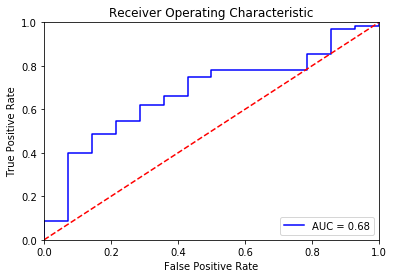

AUC Score: 0.6764705882352942
BASE PREDICTIONS ALSO ADDED TO STACK metatrain_stack df
-----------------------------------------------------------------------


In [137]:
#Instantiate the model, we have to balance the classes 
LR = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)
#balance classes
class_penalty =['balanced']
# Create hyperparameter options, we also have to balance the classes
hyperparameters = dict(C=C, class_weight = class_penalty, penalty=penalty)
#CALL FUNCTION
predictions,probs, best_model = fitandpredict(LR,hyperparameters)
#make predictions on x_test for meta models to use later
meta_pred = best_model.predict_proba(x_test)
meta_probs = []
for probability in meta_pred:
    meta_probs.append(probability[0])
metatest_stack['LR'] = meta_probs
print('BASE PREDICTIONS ALSO ADDED TO STACK metatrain_stack df')
print('-----------------------------------------------------------------------')

***The AUC Score tells us that there is a 67% chance of differentiating wins and losses*** Lets add the predictions to our prediction stacks and move on to another model


In [138]:
#add predictions and probs to dfs
LR_probs = []
for probability in probs:
    LR_probs.append(probability[0])
metatrain_stack['LR'] = LR_probs
pred_stack['LR'] = predictions

In [143]:
metatest_stack.head()

,Actual Result Bin,LR
1,1,1.114523e-04
7,1,4.479816e-03
14,1,2.419186e-08
16,1,7.553479e-02
20,1,5.510819e-03


In [144]:
metatrain_stack.head()

,Actual Result,LR
201,38,0.000009
144,21,0.068461
149,8,0.012788
99,16,0.544329
72,6,0.248109


In [145]:
pred_stack.head()

,Actual Result Bin,Actual Result,LR
201,1,38,1
144,1,21,1
149,1,8,1
99,1,16,0
72,1,6,1


## 2.3 Random Forrests

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  4.2min finished


-----------------------------------------------------------------------
Best Penalty: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
-----------------------------------------------------------------------
SPECIFICITY:  0.07142857142857142
SENSITIVITY:  0.9705882352941176
FPR:  0.9285714285714286
-----------------------------------------------------------------------


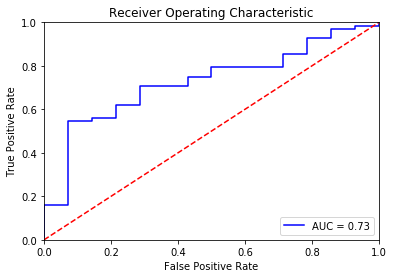

AUC Score: 0.7258403361344538
BASE PREDICTIONS ALSO ADDED TO STACK metatrain_stack df
-----------------------------------------------------------------------


In [156]:
#Instantiate the model 
RF = RandomForestClassifier()
# Create hyperparameter options
param_grid = { 
    'n_estimators': [150,300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5],
    'min_samples_leaf':[1,2,3],
    'criterion' :['gini', 'entropy'],
    'class_weight':['balanced']
}
#CALL FUNCTION
predictions,probs, best_model = fitandpredict(RF,param_grid)
#make predictions on x_test for meta models to use later
meta_pred = best_model.predict_proba(x_test)
meta_probs = []
for probability in meta_pred:
    meta_probs.append(probability[0])
metatest_stack['RF'] = meta_probs
print('BASE PREDICTIONS ALSO ADDED TO STACK metatrain_stack df')
print('-----------------------------------------------------------------------')

In [157]:
#add predictions and probs to dfs
RF_probs = []
for probability in probs:
    RF_probs.append(probability[0])
metatrain_stack['RF'] = RF_probs
pred_stack['RF'] = predictions

In [164]:
pred_stack.head()

,Actual Result Bin,Actual Result,LR,RF,NN
201,1,38,1,1,1
144,1,21,1,1,1
149,1,8,1,1,1
99,1,16,0,1,1
72,1,6,1,1,1


In [165]:
metatest_stack.head()

,Actual Result Bin,LR,RF,NN
1,1,1.114523e-04,0.110375,0.004819
7,1,4.479816e-03,0.154667,0.030964
14,1,2.419186e-08,0.060032,0.000208
16,1,7.553479e-02,0.254305,0.037557
20,1,5.510819e-03,0.046074,0.006049


In [166]:
metatrain_stack.head()

,Actual Result,LR,RF,NN
201,38,0.000009,0.031202,0.002068
144,21,0.068461,0.085743,0.019836
149,8,0.012788,0.001460,0.011266
99,16,0.544329,0.218830,0.172274
72,6,0.248109,0.445898,0.124045


## 2.4 NN

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  8.5min finished


-----------------------------------------------------------------------
Best Penalty: {'activation': 'logistic', 'alpha': 0.1, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 500, 'momentum': 0.9, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
-----------------------------------------------------------------------
SPECIFICITY:  0.14285714285714285
SENSITIVITY:  0.9705882352941176
FPR:  0.8571428571428572
-----------------------------------------------------------------------


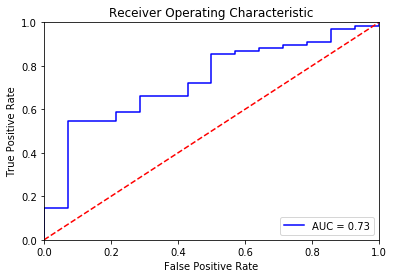

AUC Score: 0.73109243697479
BASE PREDICTIONS ALSO ADDED TO STACK metatrain_stack df
-----------------------------------------------------------------------


In [161]:
#Instantiate the model 
NN = MLPClassifier()

# Create hyperparameter options
parameters = {'solver': ['lbfgs'], 'max_iter': [500,1000,1500], 'alpha': 10.0 ** -np.arange(1, 7)
              ,'activation':['tanh','logistic'],
               'hidden_layer_sizes':[(100,10),(10,10),(100,100)]}
#CALL FUNCTION
predictions,probs, best_model = fitandpredict(NN,parameters)
#make predictions on x_test for meta models to use later
meta_pred = best_model.predict_proba(x_test)
meta_probs = []
for probability in meta_pred:
    meta_probs.append(probability[0])
metatest_stack['NN'] = meta_probs
print('BASE PREDICTIONS ALSO ADDED TO STACK metatrain_stack df')
print('-----------------------------------------------------------------------')

In [162]:
#add predictions and probs to dfs
NN_probs = []
for probability in probs:
    NN_probs.append(probability[0])
metatrain_stack['NN'] = NN_probs
pred_stack['NN'] = predictions

In [163]:
prob_stack.head()

,Actual Result Bin,Actual Result,LR,RF,NN,abc
69,0,-5,0.000009,0.049073,0.002372,0.294544
132,1,8,0.068462,0.067572,0.020464,0.294544
192,1,13,0.012789,0.007049,0.011533,0.294544
100,0,-13,0.544332,0.181127,0.172418,0.294544
22,1,17,0.248110,0.359685,0.127303,0.294544


## 2.5 SVC

In [167]:
from sklearn.svm import SVC
#Instantiate the model 
svc = SVC()

# Create hyperparameter options
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
#CALL FUNCTION
predictions,probs,best_model = fitandpredict(svc,param_grid)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
-----------------------------------------------------------------------
Best Penalty: {'C': 1, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
-----------------------------------------------------------------------
SPECIFICITY:  0.0
SENSITIVITY:  1.0
FPR:  1.0
-----------------------------------------------------------------------
MODEL DOES NOT RETURN PROBS, ONLY PREDICTIONS


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    1.3s finished


**This model performs poorly and we will not be taking this model forward**

## 2.6 AdaBoost

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done 630 out of 630 | elapsed:  4.2min finished


-----------------------------------------------------------------------
Best Penalty: {'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.01, 'n_estimators': 1, 'random_state': None}
-----------------------------------------------------------------------
SPECIFICITY:  0.2857142857142857
SENSITIVITY:  0.9117647058823529
FPR:  0.7142857142857143
-----------------------------------------------------------------------


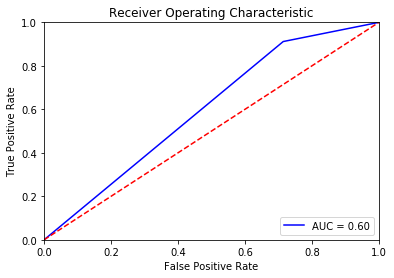

AUC Score: 0.5987394957983193
BASE PREDICTIONS ALSO ADDED TO STACK metatrain_stack df
-----------------------------------------------------------------------


In [168]:
#Instantiate the model 
abc = AdaBoostClassifier()

# Create hyperparameter options
param_grid = {
              "n_estimators": [1,10,25,50,100,200,500],
              "algorithm" : ['SAMME', 'SAMME.R'],
              "learning_rate":[0.01,0.05,0.1,0.3,1.0,1.2,1.5,1.7,2.0]
             }
             
#CALL FUNCTION
predictions,probs,best_model = fitandpredict(abc,param_grid)
#make predictions on x_test for meta models to use later
meta_pred = best_model.predict_proba(x_test)
meta_probs = []
for probability in meta_pred:
    meta_probs.append(probability[0])
metatest_stack['ada'] = meta_probs
print('BASE PREDICTIONS ALSO ADDED TO STACK metatrain_stack df')
print('-----------------------------------------------------------------------')

In [169]:
#add predictions and probs to dfs
ada_probs = []
for probability in probs:
    ada_probs.append(probability[0])
metatrain_stack['ada'] = ada_probs
pred_stack['ada'] = predictions

In [170]:
metatrain_stack.head()

,Actual Result,LR,RF,NN,ada
201,38,0.000009,0.031202,0.002068,0.294544
144,21,0.068461,0.085743,0.019836,0.294544
149,8,0.012788,0.001460,0.011266,0.294544
99,16,0.544329,0.218830,0.172274,0.294544
72,6,0.248109,0.445898,0.124045,0.294544


In [172]:
pred_stack.head()

,Actual Result Bin,Actual Result,LR,RF,NN,ada
201,1,38,1,1,1,1
144,1,21,1,1,1,1
149,1,8,1,1,1,1
99,1,16,0,1,1,1
72,1,6,1,1,1,1


In [173]:
metatest_stack.head()

,Actual Result Bin,LR,RF,NN,ada
1,1,1.114523e-04,0.110375,0.004819,0.294544
7,1,4.479816e-03,0.154667,0.030964,0.731059
14,1,2.419186e-08,0.060032,0.000208,0.294544
16,1,7.553479e-02,0.254305,0.037557,0.294544
20,1,5.510819e-03,0.046074,0.006049,0.294544


## 2.7 GaussianNB
There are no hyperparamters to tune

In [175]:
gnb = GaussianNB()
gnb.fit(x_basetrain, y_basetrain)
predictions = gnb.predict(x_basetest)
probs = gnb.predict_proba(x_basetest)

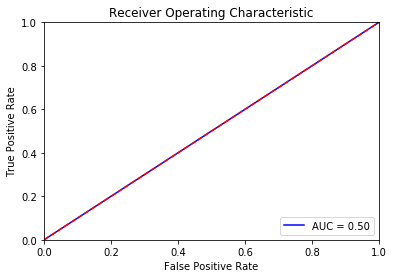

AUC Score: 0.5


In [176]:
preds = probs[:,1]#keep probabilities for the positive outcome only
fpr, tpr, threshold = metrics.roc_curve(y_basetest_bin, preds)
roc_auc = metrics.auc(fpr, tpr)
# plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC Score:',roc_auc)

***WORST MODEL SO FAR, it will not be taken forward***

# 3.0 Meta Modeling
## 3.1 Stack prep
First lets prepare our train and test stacks

In [180]:
metatrain_stack.head()

,Actual Result,LR,RF,NN,ada
201,38,0.000009,0.031202,0.002068,0.294544
144,21,0.068461,0.085743,0.019836,0.294544
149,8,0.012788,0.001460,0.011266,0.294544
99,16,0.544329,0.218830,0.172274,0.294544
72,6,0.248109,0.445898,0.124045,0.294544


In [182]:
pred_stack.head()

,Actual Result Bin,Actual Result,LR,RF,NN,ada
201,1,38,1,1,1,1
144,1,21,1,1,1,1
149,1,8,1,1,1,1
99,1,16,0,1,1,1
72,1,6,1,1,1,1


In [179]:
metatest_stack.head()

,Actual Result Bin,LR,RF,NN,ada
1,1,1.114523e-04,0.110375,0.004819,0.294544
7,1,4.479816e-03,0.154667,0.030964,0.731059
14,1,2.419186e-08,0.060032,0.000208,0.294544
16,1,7.553479e-02,0.254305,0.037557,0.294544
20,1,5.510819e-03,0.046074,0.006049,0.294544


## 3.2 Meta Model 1 - Gradient Boosting Classifier


In [ ]:
len(y_test_bin)